### Intrinsic Calibration

In this notebook we will build a generic pipeline for camera [intrinsic calibration](https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-for-camera-calibration-in-computer-vision/). We will be working with data that you can download from this public [repository](https://github.com/udacity/CarND-Advanced-Lane-Lines).

The objective is to find the parameters of the camera optical system, i.e., its optical center, focal length and radial (or tangential) distortion coefficients of the lens.

**Calibration Pipeline**
 - We will assume that the calibration target has not moved throughout the calibration (it might have moved but this does not affect the calibration). What is the position of the camera,relative to the reference target position, that has been used to take the pixture? -> rvecs, tvecs
 - We know the targets are flat and rectangular (all the corners are colinear). What are the distortion model parameters that would minimize the undistortion error?

In [1]:
import os
import cv2
import numpy as np

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [20, 4]

#### Load Calibration Images

We start by taking images of the calibration pattern (typically a chessboard structure). Remember that camera calibration is an optimization process. We shall take multiple pictures and tray to cover the whole image area.

Num images 20


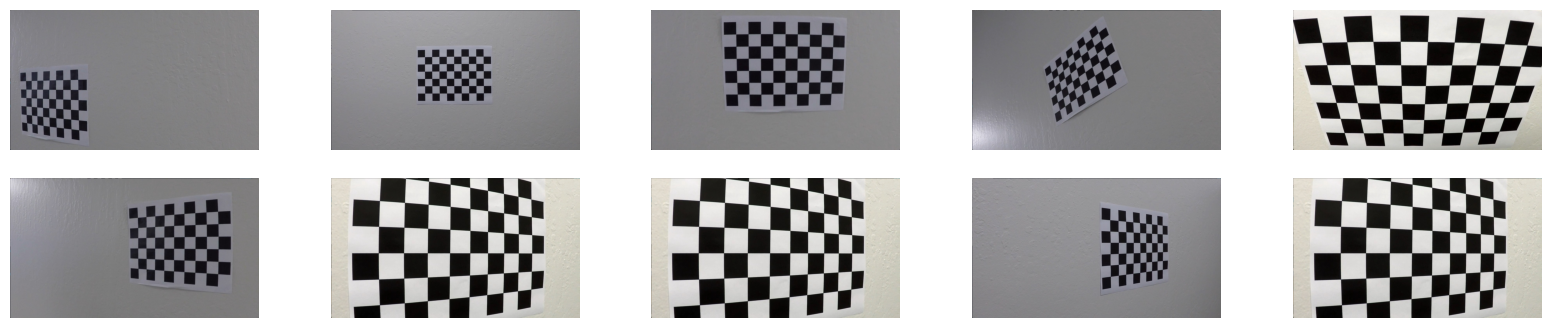

In [3]:
folder = '/home/janko/Projects/robot_dreams/cv/data/camera_cal'
fnames = os.listdir(folder)

print('Num images', len(fnames))

for idx, fname in enumerate(np.random.choice(fnames, 10)):
    image = cv2.cvtColor(cv2.imread(os.path.join(folder, fname)), cv2.COLOR_BGR2RGB)
    plt.subplot(2,5,idx+1), plt.imshow(image), plt.axis(False)

#### Calibration Parameters Setup

In [4]:
# Target shape, i.e., the number of **inner** corners
target_rows, target_cols = 6, 9

# Optimization termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare target reference 3D points, i.e., (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
pts_ref = np.zeros((target_rows * target_cols, 3), np.float32)
pts_ref[:,:2] = np.mgrid[0:target_cols, 0:target_rows].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images.
pts_tgt = [] # 3D point in real world space
pts_img = [] # 2D points in image plane

#### Detect Target Corners

In this step, we are going to detect the inner corners of the calibration pattern.

In [5]:
detections = []

for fname in fnames:
    image = cv2.imread(os.path.join(folder, fname))
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Detect target corners
    ret, corners = cv2.findChessboardCorners(gray, (target_cols, target_rows), None)
    
    # Refine the detected corners and add them to the calibration dataset
    if ret == True:
        # Target keypoints (always correspond to reference points)
        pts_tgt.append(pts_ref)
        
        # Refine image points with subpixel precision and add them to dataset
        corners = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        pts_img.append(corners)
        
        # Draw and display the corners
        detection = np.copy(image)
        cv2.drawChessboardCorners(detection, (target_cols, target_rows), corners, ret)
        detections.append(detection)

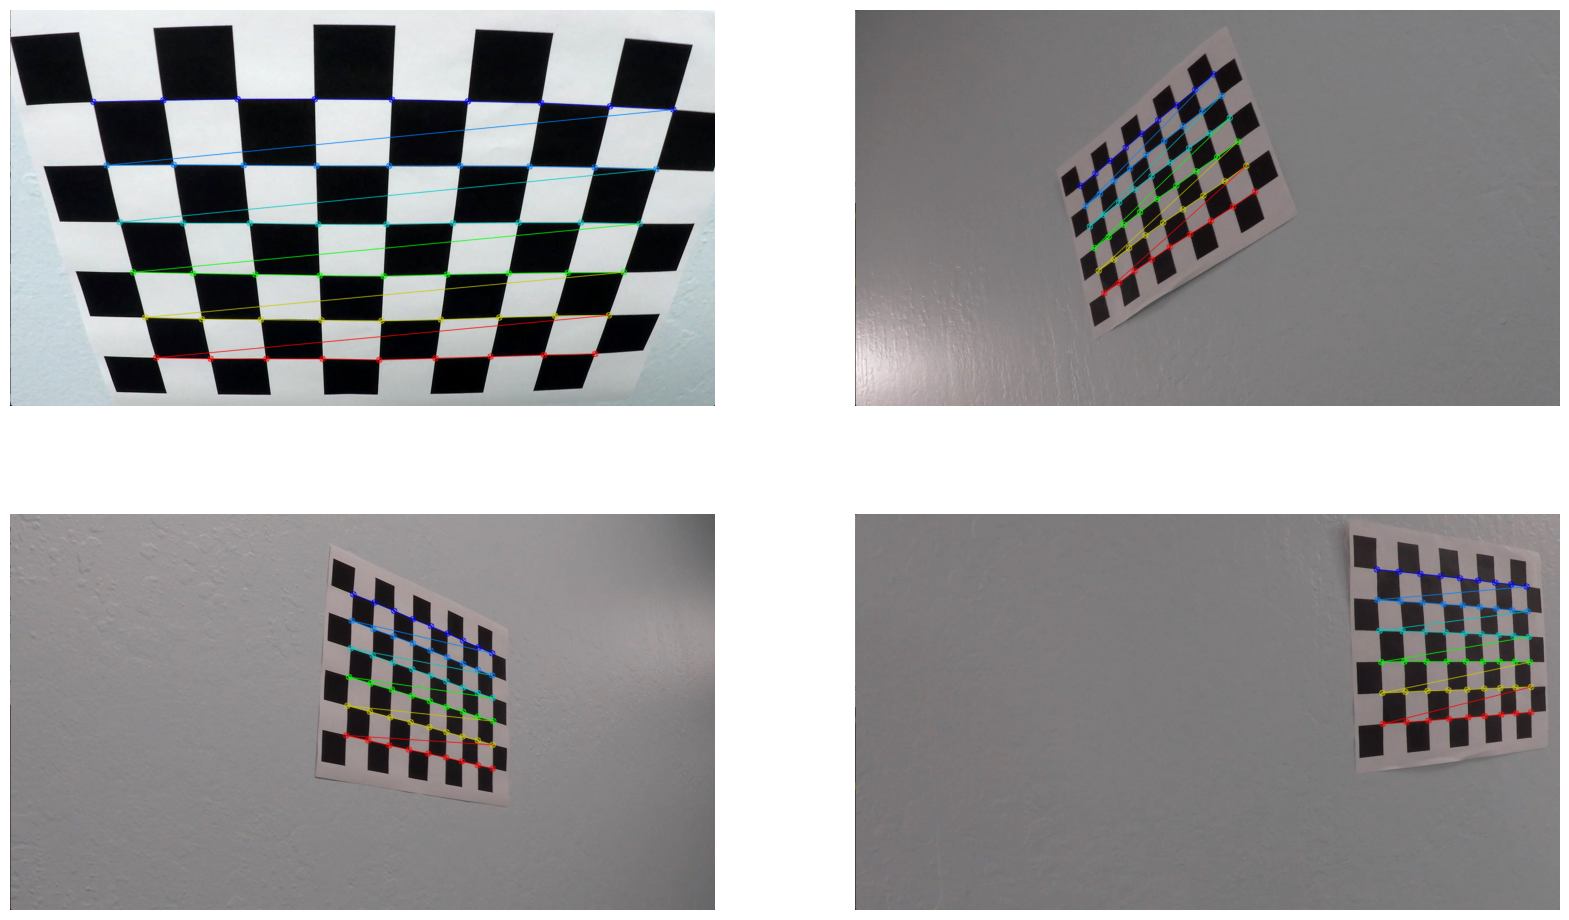

In [17]:
# Visualize random samples with the detected keypoints
plt.rcParams['figure.figsize'] = [20, 12]
for cnt, idx in enumerate(np.random.randint(0, len(detections), 4)):
    plt.subplot(2,2,cnt+1), plt.imshow(detections[idx]), plt.axis(False)

#### Perform Camera Intrinsic Calibration

(<Axes: >, <matplotlib.image.AxesImage at 0x70e4c1cf3740>)

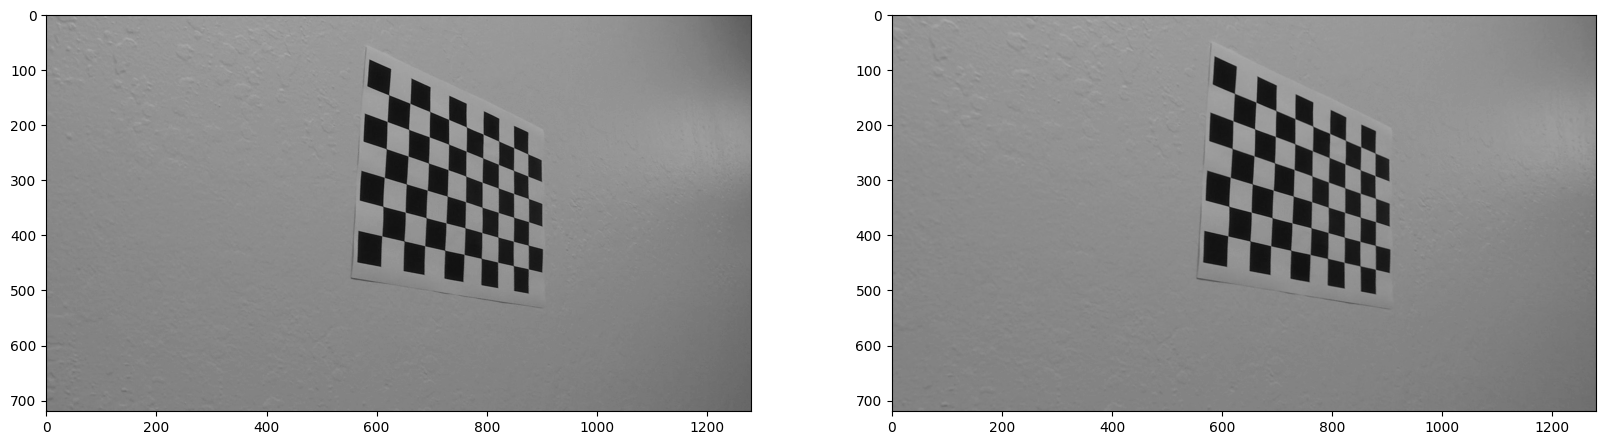

In [18]:
# Main calibration optimization process
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(pts_tgt, pts_img, gray.shape[::-1], None, None)

# Undistort
dst = cv2.undistort(gray, mtx, dist)


plt.subplot(121), plt.imshow(gray, cmap='gray', vmin=0, vmax=255)
plt.subplot(122), plt.imshow(dst, cmap='gray', vmin=0, vmax=255)

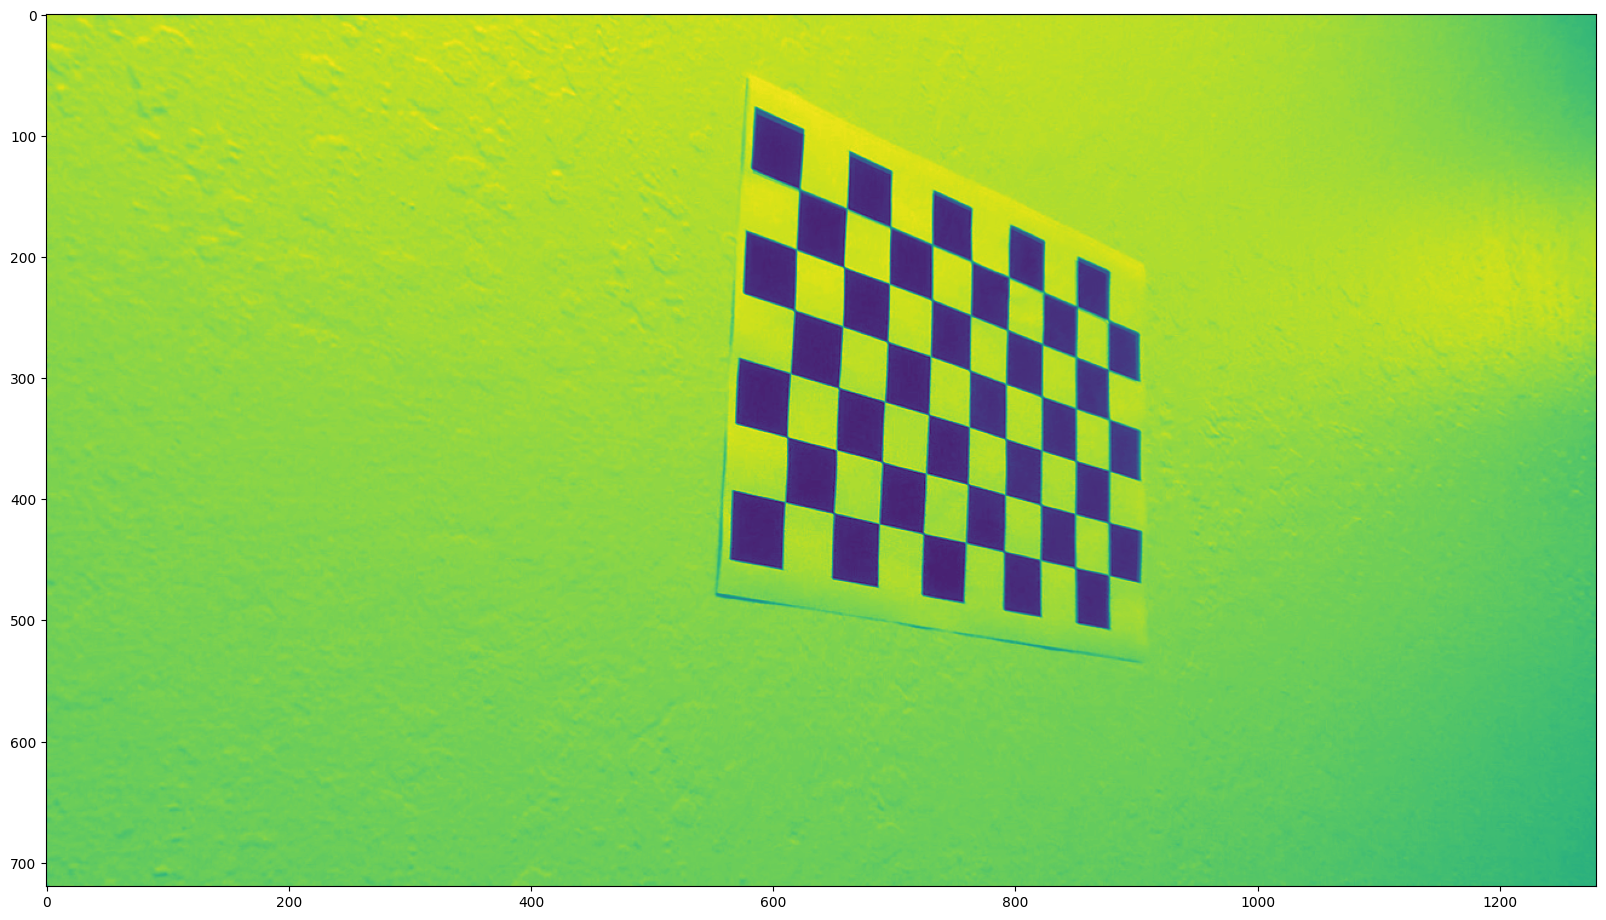

In [19]:
result = cv2.addWeighted(dst, 1.0, gray, 0.25, gamma=0)
plt.imshow(result)

In [ ]:
mtx

In [ ]:
dst.shape, gray.shape

#### Visualize Random Sample

In [ ]:
image = cv2.imread(os.path.join(folder, np.random.choice(fnames)))
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
dst = cv2.undistort(gray, mtx, dist)

result = cv2.addWeighted(dst, 1.0, gray, 0.25, gamma=0)
plt.imshow(result, cmap='gray')